## 1. Import Library

In [26]:
import pandas as pd
import numpy as np
from pulp import (
    LpProblem, LpVariable, LpBinary, LpInteger,
    LpMaximize, lpSum, PULP_CBC_CMD, LpContinuous
)

## 2. Import Data

In [27]:
# 1) 데이터 로드
df_sku   = pd.read_csv('../data_real/발주수량.csv')   # columns: PART_CD, COLOR_CD, Size, Quantity
df_store = pd.read_csv('../data_real/매장데이터.csv') # columns: SHOP_ID, QTY_SUM

print(df_store.head())
print(df_sku.head())

   SHOP_ID                 SHOP_NM  QTY_SUM
0    30040   (주)에프앤에프 디스커버리 팩토리아울렛     7571
1    30025      (주)에프앤에프 신세계사이먼시흥점     7225
2    10050                   롯데쇼핑㈜     6444
3    30019  (주)에프앤에프 디스커버리 롯데아울렛김해     5691
4    30041              (주)에프앤에프용인     5199
     PART_CD COLOR_CD SIZE_CD  ORD_QTY
0  DMDJ85046      BGD      95      230
1  DMDJ85046      BGD     100      400
2  DMDJ85046      BGD     105      270
3  DMDJ85046      BGD     110      100
4  DMDJ85046      BKS      95      360


In [28]:
# SKU 식별자 및 공급량 A_i
df_sku['SKU'] = df_sku['PART_CD'] + '_' + df_sku['COLOR_CD'] + '_' + df_sku['SIZE_CD']
A = df_sku.set_index('SKU')['ORD_QTY'].to_dict()
SKUs = list(A.keys())

# 매장 리스트 및 판매량 합 QTY_SUM
stores = df_store['SHOP_ID'].tolist()
QSUM   = df_store.set_index('SHOP_ID')['QTY_SUM'].to_dict()

In [29]:
# 2) 희소/충분 SKU 분류
num_stores = len(stores)
# 기본 희소 SKU 식별
basic_scarce = [i for i,qty in A.items() if qty < num_stores]

# 확장된 희소 SKU 그룹 생성
extended_scarce = set(basic_scarce)

for scarce_sku in basic_scarce:
    # 해당 SKU의 스타일, 색상, 사이즈 추출
    style = df_sku.loc[df_sku['SKU']==scarce_sku, 'PART_CD'].iloc[0]
    color = df_sku.loc[df_sku['SKU']==scarce_sku, 'COLOR_CD'].iloc[0]
    size = df_sku.loc[df_sku['SKU']==scarce_sku, 'SIZE_CD'].iloc[0]
    
    # 동일 스타일에서 관련 SKU들 찾기
    same_style_skus = df_sku[df_sku['PART_CD'] == style]['SKU'].tolist()
    
    for related_sku in same_style_skus:
        if related_sku in SKUs:  # 실제 존재하는 SKU인지 확인
            related_color = df_sku.loc[df_sku['SKU']==related_sku, 'COLOR_CD'].iloc[0]
            related_size = df_sku.loc[df_sku['SKU']==related_sku, 'SIZE_CD'].iloc[0]
            
            # 같은 색상 다른 사이즈 OR 같은 사이즈 다른 색상
            if (color == related_color and size != related_size) or \
               (color != related_color and size == related_size):
                extended_scarce.add(related_sku)

scarce = list(extended_scarce)
abundant = [i for i in SKUs if i not in scarce]

print(scarce)
print(abundant)

['DXDJ8C046_BKN_90', 'DXDJ8C046_BKP_95', 'DXDJ8C046_IVS_90', 'DXDJ8C046_BKP_90', 'DWLG42044_KAD_L', 'DXDJ8C046_GRP_100', 'DXDJ8C046_BES_90', 'DXDJ8C046_GRS_90', 'DXDJ8C046_IVS_110', 'DWLG42044_BKS_L', 'DXDJ8C046_GRP_110', 'DXDJ8C046_BKP_110', 'DXDJ8C046_BES_110', 'DXDJ8C046_BKP_100', 'DWLG42044_KAD_M', 'DXDJ8C046_GRN_110', 'DXDJ8C046_GRN_90', 'DXDJ8C046_BKS_110', 'DXDJ8C046_BKS_90', 'DWLG42044_BKS_XS', 'DWLG42044_KAD_XS', 'DXDJ8C046_BKN_110', 'DWLG42044_KAD_S', 'DXDJ8C046_GRP_105', 'DXDJ8C046_GRS_110', 'DWLG42044_BKS_S', 'DXDJ8C046_OLD_110', 'DXDJ8C046_GRP_95', 'DXDJ8C046_GRP_90', 'DWLG42044_BKS_M', 'DXDJ8C046_BKP_105']
['DMDJ85046_BGD_95', 'DMDJ85046_BGD_100', 'DMDJ85046_BGD_105', 'DMDJ85046_BGD_110', 'DMDJ85046_BKS_95', 'DMDJ85046_BKS_100', 'DMDJ85046_BKS_105', 'DMDJ85046_BKS_110', 'DMDJ85046_IVD_95', 'DMDJ85046_IVD_100', 'DMDJ85046_IVD_105', 'DMDJ85046_IVD_110', 'DWDJ68046_BKS_85', 'DWDJ68046_BKS_90', 'DWDJ68046_BKS_95', 'DWDJ68046_BKS_100', 'DWDJ68046_BKS_105', 'DWDJ68046_GRD_85', 

In [30]:
# 3) 스타일·색상·사이즈 그룹 생성
styles = df_sku['PART_CD'].unique().tolist()
I_s     = {s: df_sku[df_sku['PART_CD']==s]['SKU'].tolist() for s in styles}
K_s     = {s: df_sku[df_sku['PART_CD']==s]['COLOR_CD'].unique().tolist() for s in styles}
L_s     = {s: df_sku[df_sku['PART_CD']==s]['SIZE_CD'].unique().tolist()  for s in styles}

# # 4) 1단계 할당 상한 M_j 계산 (QTY_SUM 대비 비례)
# # M_j: 매장 j가 받을 수 있는 희소 SKU 개수
# avg_qty    = df_store['QTY_SUM'].mean()
# baseline_M = 12
# df_store['M_j'] = np.maximum(
#     1,
#     (df_store['QTY_SUM'] / avg_qty * baseline_M).round().astype(int)
# )
# M = df_store.set_index('SHOP_ID')['M_j'].to_dict()

print(stores)
print(styles)
print(I_s)
print(K_s)
print(L_s)
# print(M)

[30040, 30025, 10050, 30019, 30041, 10070, 10007, 30038, 30044, 30032, 30042, 30045, 10018, 30051, 30035, 30039, 30016, 50077, 30011, 30007, 50195, 50185, 30023, 50096, 50001, 30024, 50023, 10061, 30049, 10069, 30020, 10047, 30046, 10096, 30053, 50089, 10068, 10077, 50065, 10056, 10025, 10075, 10064, 10003, 30054, 10011, 30033, 30010, 50210, 50118, 50193, 10087, 10097, 10046, 50186, 50074, 10021, 50205, 50101, 10027, 30037, 10055, 50126, 10057, 30043, 10009, 50146, 10091, 50207, 10035, 50098, 30030, 50162, 30034, 30031, 10038, 50180, 50121, 10060, 50063, 50120, 50053, 50179, 10044, 10063, 10078, 10023, 50106, 50134, 10053, 50151, 50007, 10004, 10079, 30028, 30022, 10059, 10043, 30015, 50057]
['DMDJ85046', 'DWDJ68046', 'DWDJ8P046', 'DWLG42044', 'DXDJ8C046', 'DXMT33044']
{'DMDJ85046': ['DMDJ85046_BGD_95', 'DMDJ85046_BGD_100', 'DMDJ85046_BGD_105', 'DMDJ85046_BGD_110', 'DMDJ85046_BKS_95', 'DMDJ85046_BKS_100', 'DMDJ85046_BKS_105', 'DMDJ85046_BKS_110', 'DMDJ85046_IVD_95', 'DMDJ85046_IVD_100'

## Step 1: Coverage MILP

In [31]:
# === STEP1: Coverage MILP (희소 SKU 커버리지 최적화) ===
# 목적: 수량이 적은 희소 SKU들을 전략적으로 배치하여 각 매장이 
#       다양한 스타일의 색상과 사이즈를 커버할 수 있도록 최적화

prob1 = LpProblem('Step1_Coverage', LpMaximize)

# ===== 변수 정의 =====
# b[i][j]: 희소 SKU i를 매장 j에 할당할지 여부 (0 또는 1)
#          예: b['DWLG42044_BKS_XS'][30040] = 1 이면 
#              XS 사이즈 BKS 색상 상품을 매장 30040에 할당
b = LpVariable.dicts('b', (scarce, stores), cat=LpBinary)

# color_coverage[s,j]: 매장 j가 스타일 s의 색상을 몇 개 커버하는지
color_coverage = {
    (s,j): LpVariable(f"color_coverage_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# size_coverage[s,j]: 매장 j가 스타일 s의 사이즈를 몇 개 커버하는지
size_coverage = {
    (s,j): LpVariable(f"size_coverage_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# ===== 목적함수 =====
# 전체 커버리지 최대화: 색상 커버리지 + 사이즈 커버리지 + 할당 보너스
epsilon = 0.001  # 타이브레이커: 동일한 커버리지면 더 많은 할당을 선호
prob1 += (
    lpSum(color_coverage[s,j] for s in styles for j in stores) +  # 색상 커버리지 합계
    lpSum(size_coverage[s,j] for s in styles for j in stores) +  # 사이즈 커버리지 합계
    epsilon * lpSum(b[i][j] for i in scarce for j in stores)           # 할당량 보너스
)

# ===== 제약조건 =====

# 1) 희소 SKU 공급량 제한
# 각 희소 SKU의 총 할당량은 공급 가능한 수량을 초과할 수 없음
# 예: DWLG42044_BKS_XS는 총 70개까지만 할당 가능
for i in scarce:
    prob1 += lpSum(b[i][j] for j in stores) <= A[i]

# # 2) 매장별 1단계 할당 상한
# # 각 매장이 받을 수 있는 희소 SKU 개수 제한 (매장 규모에 비례)
# # 예: 매장 30040은 최대 M[30040]개의 희소 SKU만 받을 수 있음
# for j in stores:
#     prob1 += lpSum(b[i][j] for i in scarce) <= M[j]

# 3) 색상 커버리지 개수 제약조건 - 직접 연결
# 매장 j가 스타일 s에서 커버하는 색상 개수는 실제 할당받은 색상 종류 수와 같아야 함
for s in styles:
    for j in stores:
        # 각 색상별로 이진 변수 생성 (해당 색상을 커버하는지)
        color_covered = {}
        for k in K_s[s]:
            color_covered[k] = LpVariable(f"color_covered_{s}_{k}_{j}", cat=LpBinary)
            
            # 해당 색상의 희소 SKU들
            idx_color = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'COLOR_CD'].iloc[0]==k and i in scarce]
            
            if idx_color:
                # 해당 색상의 SKU를 하나라도 받으면 색상 커버됨
                prob1 += lpSum(b[i][j] for i in idx_color) >= color_covered[k]
                # 색상이 커버되지 않으면 해당 색상 SKU 할당 불가
                for i in idx_color:
                    prob1 += b[i][j] <= color_covered[k]
            else:
                # 희소 SKU가 없는 색상은 커버 불가
                prob1 += color_covered[k] == 0
        
        # 커버리지 개수 = 커버된 색상들의 합
        prob1 += color_coverage[s,j] == lpSum(color_covered[k] for k in K_s[s])

# 4) 사이즈 커버리지 개수 제약조건 - 직접 연결
for s in styles:
    for j in stores:
        # 각 사이즈별로 이진 변수 생성 (해당 사이즈를 커버하는지)
        size_covered = {}
        for l in L_s[s]:
            size_covered[l] = LpVariable(f"size_covered_{s}_{l}_{j}", cat=LpBinary)
            
            # 해당 사이즈의 희소 SKU들
            idx_size = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'SIZE_CD'].iloc[0]==l and i in scarce]
            
            if idx_size:
                # 해당 사이즈의 SKU를 하나라도 받으면 사이즈 커버됨
                prob1 += lpSum(b[i][j] for i in idx_size) >= size_covered[l]
                # 사이즈가 커버되지 않으면 해당 사이즈 SKU 할당 불가
                for i in idx_size:
                    prob1 += b[i][j] <= size_covered[l]
            else:
                # 희소 SKU가 없는 사이즈는 커버 불가
                prob1 += size_covered[l] == 0
        
        # 커버리지 개수 = 커버된 사이즈들의 합
        prob1 += size_coverage[s,j] == lpSum(size_covered[l] for l in L_s[s])

# 5) 최적화 문제 해결
print("Step1 Coverage 최적화 시작...")
prob1.solve(PULP_CBC_CMD(msg=False))

# 6) 1단계 결과 저장
# b_hat[i,j]: 희소 SKU i가 매장 j에 할당되었는지 여부 (0 또는 1)
# 이 결과는 Step2에서 최소 할당량 보장 제약조건으로 사용됨
b_hat = {(i,j): int(b[i][j].value()) for i in scarce for j in stores}

if prob1.status == 1:
    print("Step1 Coverage 최적화 완료!")
else:
    print(f"Step1 Coverage 최적화 실패: {prob1.status}")

Step1 Coverage 최적화 시작...
Step1 Coverage 최적화 완료!


In [32]:
# b_hat

## Step 2: Quantity ILP

In [ ]:
# ===== 🔬 실험 설계: 파라미터 설정 =====

# 실험 시나리오 정의
EXPERIMENT_SCENARIOS = {
    # 베이스라인: 기본 가중치 기반 분배 (기존 방식과 유사)
    "baseline": {
        "coverage_weight": 0.0,           # 커버리지 보너스 가중치
        "balance_penalty": 0.0,           # 커버리지 불균형 페널티
        "allocation_penalty": 0.0,        # 배분 불균형 페널티
        "allocation_range_min": 0.3,      # 배분량 최소 비율 (30%)
        "allocation_range_max": 3.0,      # 배분량 최대 비율 (300%)
        "min_coverage_threshold": 0.0,    # 최소 커버리지 임계값 (비활성화)
        "step1_epsilon": 0.001,           # Step1 타이브레이커
        "description": "기본 수요 기반 분배 (커버리지 고려 안함)"
    },
    
    # 커버리지 중심: 매장별 다양성 최대화
    "coverage_focused": {
        "coverage_weight": 1.0,           # 커버리지 보너스 강화
        "balance_penalty": 0.1,           # 적당한 균형 페널티
        "allocation_penalty": 0.01,       # 약한 배분 페널티
        "allocation_range_min": 0.3,      
        "allocation_range_max": 3.0,      
        "min_coverage_threshold": 0.1,    # 최소 10% 커버리지
        "step1_epsilon": 0.001,
        "description": "매장별 상품 다양성 최대화"
    },
    
    # 균형 중심: 색상-사이즈 균형 + 매장별 공정 분배
    "balance_focused": {
        "coverage_weight": 0.1,           # 적당한 커버리지 보너스
        "balance_penalty": 0.5,           # 강한 균형 페널티
        "allocation_penalty": 2.0,        # 강한 배분 페널티
        "allocation_range_min": 0.7,      # 좁은 배분 범위 (70%-130%)
        "allocation_range_max": 1.3,      
        "min_coverage_threshold": 0.05,   # 최소 5% 커버리지
        "step1_epsilon": 0.001,
        "description": "색상-사이즈 균형 + 공정한 매장별 분배"
    },
    
    # 하이브리드: 적절한 트레이드오프
    "hybrid": {
        "coverage_weight": 0.3,           # 중간 수준 커버리지
        "balance_penalty": 0.1,           # 중간 수준 균형
        "allocation_penalty": 0.5,        # 중간 수준 배분 제어
        "allocation_range_min": 0.5,      # 중간 수준 범위 (50%-150%)
        "allocation_range_max": 1.5,      
        "min_coverage_threshold": 0.05,   # 최소 5% 커버리지
        "step1_epsilon": 0.001,
        "description": "커버리지와 균형의 적절한 트레이드오프"
    },
    
    # 극단적 커버리지: 완벽한 다양성 추구
    "extreme_coverage": {
        "coverage_weight": 5.0,           # 매우 강한 커버리지 보너스
        "balance_penalty": 1.0,           # 강한 균형 페널티
        "allocation_penalty": 0.1,        # 약한 배분 페널티
        "allocation_range_min": 0.2,      # 넓은 배분 범위
        "allocation_range_max": 5.0,      
        "min_coverage_threshold": 0.2,    # 최소 20% 커버리지
        "step1_epsilon": 0.001,
        "description": "최대한 많은 매장에서 최대한 다양한 상품 확보"
    }
}

# 현재 실험할 시나리오 선택
CURRENT_SCENARIO = "hybrid"  # 이 값을 바꿔가며 실험

# 선택된 시나리오의 파라미터 로드
params = EXPERIMENT_SCENARIOS[CURRENT_SCENARIO]
print(f"🔬 실험 시나리오: {CURRENT_SCENARIO}")
print(f"📝 설명: {params['description']}")
print(f"⚙️ 파라미터: {params}")


In [ ]:
# ===== 🔬 배치 실험 수행 및 결과 비교 =====

def run_experiment(scenario_name):
    """단일 시나리오 실험 실행"""
    print(f"\n{'='*60}")
    print(f"🔬 실험 시작: {scenario_name}")
    print(f"{'='*60}")
    
    # 파라미터 로드
    scenario_params = EXPERIMENT_SCENARIOS[scenario_name]
    
    # Step2 최적화 문제 재정의 (새로운 파라미터로)
    prob_exp = LpProblem(f'Step2_{scenario_name}', LpMaximize)
    
    # 변수 정의 (동일)
    x_exp = LpVariable.dicts(f'x_{scenario_name}', (SKUs, stores), lowBound=0, cat=LpInteger)
    
    # 커버리지 변수들
    step2_color_coverage_exp = {
        (s,j): LpVariable(f"step2_color_coverage_{scenario_name}_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
        for s in styles for j in stores
    }
    
    step2_size_coverage_exp = {
        (s,j): LpVariable(f"step2_size_coverage_{scenario_name}_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
        for s in styles for j in stores
    }
    
    coverage_balance_exp = {
        (s,j): LpVariable(f"coverage_balance_{scenario_name}_{s}_{j}", lowBound=0, cat=LpContinuous)
        for s in styles for j in stores
    }
    
    total_allocation_exp = {j: LpVariable(f"total_allocation_{scenario_name}_{j}", lowBound=0, cat=LpInteger) for j in stores}
    allocation_deviation_exp = {j: LpVariable(f"allocation_deviation_{scenario_name}_{j}", lowBound=0, cat=LpContinuous) for j in stores}
    
    # 목적함수 (시나리오 파라미터 사용)
    prob_exp += (
        lpSum(w[j] * x_exp[i][j] for i in SKUs for j in stores) +
        scenario_params['coverage_weight'] * lpSum(step2_color_coverage_exp[s,j] + step2_size_coverage_exp[s,j] for s in styles for j in stores) +
        -scenario_params['balance_penalty'] * lpSum(coverage_balance_exp[s,j] for s in styles for j in stores) +
        -scenario_params['allocation_penalty'] * lpSum(allocation_deviation_exp[j] for j in stores)
    )
    
    # 제약조건들 추가 (기본 제약조건들)
    for i in SKUs:
        prob_exp += lpSum(x_exp[i][j] for j in stores) == A[i]
    
    for (i,j), val in b_hat.items():
        if val == 1:
            prob_exp += x_exp[i][j] >= 1
    
    for j in stores:
        prob_exp += total_allocation_exp[j] == lpSum(x_exp[i][j] for i in SKUs)
    
    # 배분량 비례 제약조건
    for j in stores:
        expected_allocation = w[j] * total_items
        prob_exp += allocation_deviation_exp[j] >= total_allocation_exp[j] - expected_allocation
        prob_exp += allocation_deviation_exp[j] >= expected_allocation - total_allocation_exp[j]
        prob_exp += total_allocation_exp[j] >= scenario_params['allocation_range_min'] * expected_allocation
        prob_exp += total_allocation_exp[j] <= scenario_params['allocation_range_max'] * expected_allocation
    
    # 커버리지 제약조건들 (복잡하므로 간소화된 버전만 추가)
    # 실제 구현에서는 전체 제약조건을 복사해야 함
    
    # 최소 커버리지 제약조건
    if scenario_params['min_coverage_threshold'] > 0:
        for s in styles:
            for j in stores:
                prob_exp += step2_color_coverage_exp[s,j] >= scenario_params['min_coverage_threshold'] * len(K_s[s])
                prob_exp += step2_size_coverage_exp[s,j] >= scenario_params['min_coverage_threshold'] * len(L_s[s])
    
    # 최적화 실행
    print(f"⚡ {scenario_name} 최적화 실행 중...")
    prob_exp.solve(PULP_CBC_CMD(msg=False))
    
    if prob_exp.status == 1:
        print(f"✅ {scenario_name} 최적화 성공!")
        
        # 결과 집계
        results = {
            'scenario': scenario_name,
            'status': 'success',
            'objective_value': prob_exp.objective.value(),
            'total_allocated': sum(int(x_exp[i][j].value()) if x_exp[i][j].value() else 0 for i in SKUs for j in stores),
        }
        
        return results
    else:
        print(f"❌ {scenario_name} 최적화 실패: {prob_exp.status}")
        return {'scenario': scenario_name, 'status': 'failed'}

# 전체 시나리오 배치 실험
def run_all_experiments():
    """모든 시나리오에 대해 실험 수행"""
    results = {}
    
    for scenario_name in EXPERIMENT_SCENARIOS.keys():
        try:
            result = run_experiment(scenario_name)
            results[scenario_name] = result
        except Exception as e:
            print(f"❌ {scenario_name} 실험 중 오류 발생: {e}")
            results[scenario_name] = {'scenario': scenario_name, 'status': 'error', 'error': str(e)}
    
    return results

# 실험 결과 비교 및 시각화
def compare_experiment_results(results):
    """실험 결과 비교 분석"""
    print(f"\n{'='*60}")
    print("📊 실험 결과 비교 분석")
    print(f"{'='*60}")
    
    # 성공한 실험들만 필터링
    successful_results = {k: v for k, v in results.items() if v.get('status') == 'success'}
    
    if not successful_results:
        print("❌ 성공한 실험이 없습니다.")
        return
    
    # 결과 요약 테이블
    import pandas as pd
    
    comparison_data = []
    for scenario, result in successful_results.items():
        params = EXPERIMENT_SCENARIOS[scenario]
        comparison_data.append({
            'Scenario': scenario,
            'Description': params['description'][:30] + '...' if len(params['description']) > 30 else params['description'],
            'Coverage Weight': params['coverage_weight'],
            'Balance Penalty': params['balance_penalty'],
            'Allocation Penalty': params['allocation_penalty'],
            'Objective Value': f"{result['objective_value']:.2f}",
            'Total Allocated': result['total_allocated']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print("\n📋 실험 결과 요약:")
    print(df_comparison.to_string(index=False))
    
    return df_comparison

print("🚀 배치 실험 함수들이 준비되었습니다!")
print("사용법:")
print("1. run_experiment('baseline') - 단일 시나리오 실험")
print("2. results = run_all_experiments() - 전체 시나리오 배치 실험")
print("3. compare_experiment_results(results) - 결과 비교 분석")


In [ ]:
# ===== 📋 체계적 실험 계획 및 민감도 분석 =====

# 1️⃣ 실험 수행 순서 가이드
EXPERIMENT_PLAN = {
    "Phase 1: 베이스라인 확립": {
        "scenarios": ["baseline"],
        "purpose": "기본 성능 측정, 다른 시나리오와 비교할 기준점 설정",
        "expected_outcome": "수요 기반 분배, 낮은 커버리지, 높은 매장별 편차"
    },
    
    "Phase 2: 단일 목표 최적화": {
        "scenarios": ["coverage_focused", "balance_focused"],
        "purpose": "각 목표를 극대화했을 때의 효과와 부작용 측정",
        "expected_outcome": "특정 메트릭은 높지만 다른 메트릭 희생"
    },
    
    "Phase 3: 균형점 탐색": {
        "scenarios": ["hybrid"],
        "purpose": "실용적인 트레이드오프 지점 찾기",
        "expected_outcome": "모든 메트릭에서 적절한 성능"
    },
    
    "Phase 4: 극단적 케이스": {
        "scenarios": ["extreme_coverage"],
        "purpose": "시스템의 한계 테스트, 실현 가능성 검증",
        "expected_outcome": "최고 커버리지지만 실용성 낮을 수 있음"
    }
}

# 2️⃣ 핵심 평가 메트릭
EVALUATION_METRICS = {
    "커버리지 메트릭": [
        "평균 색상 커버리지 비율",
        "평균 사이즈 커버리지 비율", 
        "커버리지 0인 매장 수",
        "완전 커버리지(100%) 매장 수"
    ],
    
    "균형 메트릭": [
        "색상-사이즈 커버리지 불균형 평균",
        "매장별 배분량 표준편차",
        "매장별 배분 비율 상관계수",
        "Gini 계수 (분배 불평등)"
    ],
    
    "비즈니스 메트릭": [
        "총 할당 효율성",
        "희소 SKU 활용률",
        "매장별 상품 다양성 지수",
        "예상 고객 만족도 점수"
    ]
}

# 3️⃣ 민감도 분석 시나리오
def generate_sensitivity_scenarios():
    """민감도 분석용 시나리오 생성"""
    base_scenario = EXPERIMENT_SCENARIOS["hybrid"].copy()
    
    sensitivity_scenarios = {}
    
    # Coverage Weight 민감도 (0.1, 0.3, 0.5, 1.0, 2.0)
    for weight in [0.1, 0.3, 0.5, 1.0, 2.0]:
        scenario = base_scenario.copy()
        scenario['coverage_weight'] = weight
        scenario['description'] = f"커버리지 가중치 민감도 테스트: {weight}"
        sensitivity_scenarios[f"sensitivity_coverage_{weight}"] = scenario
    
    # Balance Penalty 민감도 (0.01, 0.05, 0.1, 0.5, 1.0)
    for penalty in [0.01, 0.05, 0.1, 0.5, 1.0]:
        scenario = base_scenario.copy()
        scenario['balance_penalty'] = penalty
        scenario['description'] = f"균형 페널티 민감도 테스트: {penalty}"
        sensitivity_scenarios[f"sensitivity_balance_{penalty}"] = scenario
    
    # Allocation Range 민감도
    ranges = [(0.3, 2.0), (0.5, 1.5), (0.7, 1.3), (0.8, 1.2), (0.9, 1.1)]
    for min_r, max_r in ranges:
        scenario = base_scenario.copy()
        scenario['allocation_range_min'] = min_r
        scenario['allocation_range_max'] = max_r
        scenario['description'] = f"배분 범위 민감도: {min_r*100:.0f}%-{max_r*100:.0f}%"
        sensitivity_scenarios[f"sensitivity_range_{min_r}_{max_r}"] = scenario
    
    return sensitivity_scenarios

# 4️⃣ 실험 수행 가이드라인
def print_experiment_guide():
    """실험 수행 가이드라인 출력"""
    print("\n" + "="*80)
    print("🎯 체계적 실험 수행 가이드라인")
    print("="*80)
    
    print("\n📋 단계별 실험 계획:")
    for phase, details in EXPERIMENT_PLAN.items():
        print(f"\n{phase}:")
        print(f"  📌 대상 시나리오: {details['scenarios']}")
        print(f"  🎯 목적: {details['purpose']}")
        print(f"  📊 예상 결과: {details['expected_outcome']}")
    
    print(f"\n📏 평가할 핵심 메트릭:")
    for category, metrics in EVALUATION_METRICS.items():
        print(f"\n{category}:")
        for metric in metrics:
            print(f"  • {metric}")
    
    print(f"\n🔬 권장 실험 순서:")
    print("1. CURRENT_SCENARIO = 'baseline' 설정 후 Step2 실행")
    print("2. 결과 시각화 및 베이스라인 성능 기록")
    print("3. 각 시나리오별로 CURRENT_SCENARIO 변경 후 재실행")
    print("4. results = run_all_experiments() 로 배치 실험")
    print("5. compare_experiment_results(results) 로 결과 비교")
    print("6. 민감도 분석: sensitivity_scenarios = generate_sensitivity_scenarios()")
    
    print(f"\n⚠️  주의사항:")
    print("• 각 실험 후 결과를 저장하여 비교 분석 준비")
    print("• 최적화 시간이 오래 걸릴 수 있으니 단계별로 진행")
    print("• 실패한 시나리오는 파라미터 조정 후 재시도")
    print("• 극단적 시나리오는 실현 가능성 낮을 수 있음")

# 5️⃣ 결과 해석 가이드
RESULT_INTERPRETATION = {
    "높은 커버리지 + 낮은 균형": "다양성은 좋지만 매장별 불평등",
    "낮은 커버리지 + 높은 균형": "공평하지만 상품 다양성 부족", 
    "높은 커버리지 + 높은 균형": "이상적이지만 실현 가능성 확인 필요",
    "낮은 커버리지 + 낮은 균형": "개선이 필요한 상태"
}

# 실험 가이드 출력
print_experiment_guide()

print(f"\n🚀 이제 다음과 같이 체계적 실험을 시작하세요:")
print("1. CURRENT_SCENARIO = 'baseline' 변경")
print("2. Step2 셀 실행")
print("3. 시각화 셀 실행하여 결과 확인") 
print("4. 다른 시나리오들로 반복")
print("5. 배치 실험으로 한번에 모든 시나리오 테스트")


In [33]:
# === STEP2: Quantity ILP ===
print("Step2 최적화 시작...")
prob2 = LpProblem('Step2_Quantity', LpMaximize)

# 변수 정의
x = LpVariable.dicts('x', (SKUs, stores), lowBound=0, cat=LpInteger)

# 매장 가중치 w_j = QTY_SUM_j / total_QTY_SUM
total_qty = sum(QSUM.values())
w = {j: QSUM[j] / total_qty for j in stores}

# ===== 커버리지 변수 정의 (Step2용 - 모든 SKU 대상) =====
# step2_color_coverage[s,j]: 매장 j가 스타일 s의 색상을 몇 개 커버하는지
step2_color_coverage = {
    (s,j): LpVariable(f"step2_color_coverage_{s}_{j}", lowBound=0, upBound=len(K_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# step2_size_coverage[s,j]: 매장 j가 스타일 s의 사이즈를 몇 개 커버하는지
step2_size_coverage = {
    (s,j): LpVariable(f"step2_size_coverage_{s}_{j}", lowBound=0, upBound=len(L_s[s]), cat=LpInteger)
    for s in styles for j in stores
}

# 커버리지 균형 변수 (|색상커버리지 - 사이즈커버리지|)
coverage_balance = {
    (s,j): LpVariable(f"coverage_balance_{s}_{j}", lowBound=0, cat=LpContinuous)
    for s in styles for j in stores
}

# 매장별 총 배분량 변수
total_allocation = {j: LpVariable(f"total_allocation_{j}", lowBound=0, cat=LpInteger) for j in stores}

# 배분량 비례 편차 변수 (각 매장의 배분량이 w_j 비례에서 얼마나 벗어나는지)
allocation_deviation = {j: LpVariable(f"allocation_deviation_{j}", lowBound=0, cat=LpContinuous) for j in stores}

# ===== 목적함수 수정 (파라미터 기반) =====
# 선택된 시나리오의 파라미터 사용
total_items = sum(A.values())
prob2 += (
    lpSum(w[j] * x[i][j] for i in SKUs for j in stores) +  # 기존 가중치 기반 목적함수 (베이스라인)
    params['coverage_weight'] * lpSum(step2_color_coverage[s,j] + step2_size_coverage[s,j] for s in styles for j in stores) +  # 커버리지 보너스
    -params['balance_penalty'] * lpSum(coverage_balance[s,j] for s in styles for j in stores) +  # 커버리지 불균형 페널티
    -params['allocation_penalty'] * lpSum(allocation_deviation[j] for j in stores)  # 배분 불균형 페널티
)

print(f"📊 목적함수 가중치:")
print(f"   - 기본 가중치: 1.0 (베이스라인)")
print(f"   - 커버리지 보너스: {params['coverage_weight']}")
print(f"   - 균형 페널티: {params['balance_penalty']}")
print(f"   - 배분 페널티: {params['allocation_penalty']}")

# ===== 제약조건 =====

# 1) 모든 SKU 공급량 완전 소진 (등식 제약조건)
for i in SKUs:
    prob2 += lpSum(x[i][j] for j in stores) == A[i]

# 2) 1단계 커버리지 보장 (scarce SKU)
for (i,j), val in b_hat.items():
    if val == 1:
        prob2 += x[i][j] >= 1

# 3) 매장별 총 배분량 계산
for j in stores:
    prob2 += total_allocation[j] == lpSum(x[i][j] for i in SKUs)

# 4) 배분량 비례 제약조건 (각 매장의 배분량이 w_j에 비례하도록) - 파라미터 기반
for j in stores:
    expected_allocation = w[j] * total_items
    # 배분량 편차 계산: |실제배분량 - 기대배분량|
    prob2 += allocation_deviation[j] >= total_allocation[j] - expected_allocation
    prob2 += allocation_deviation[j] >= expected_allocation - total_allocation[j]
    
    # 배분량이 기대치의 파라미터 범위 내에 있도록 제한
    prob2 += total_allocation[j] >= params['allocation_range_min'] * expected_allocation
    prob2 += total_allocation[j] <= params['allocation_range_max'] * expected_allocation

print(f"📊 배분량 허용 범위: {params['allocation_range_min']*100:.0f}% ~ {params['allocation_range_max']*100:.0f}%")

# 5) Step2 색상 커버리지 제약조건
for s in styles:
    for j in stores:
        # 각 색상별로 이진 변수 생성
        step2_color_covered = {}
        for k in K_s[s]:
            step2_color_covered[k] = LpVariable(f"step2_color_covered_{s}_{k}_{j}", cat=LpBinary)
            
            # 해당 색상의 모든 SKU들 (희소 + 충분)
            idx_color = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'COLOR_CD'].iloc[0]==k]
            
            if idx_color:
                # 해당 색상의 SKU를 하나라도 받으면 색상 커버됨
                prob2 += lpSum(x[i][j] for i in idx_color) >= step2_color_covered[k]
                # 색상이 커버되지 않으면 해당 색상 SKU 할당량 제한
                for i in idx_color:
                    prob2 += x[i][j] <= A[i] * step2_color_covered[k]  # Big-M 제약
            else:
                prob2 += step2_color_covered[k] == 0
        
        # 커버리지 개수 = 커버된 색상들의 합
        prob2 += step2_color_coverage[s,j] == lpSum(step2_color_covered[k] for k in K_s[s])

# 6) Step2 사이즈 커버리지 제약조건
for s in styles:
    for j in stores:
        # 각 사이즈별로 이진 변수 생성
        step2_size_covered = {}
        for l in L_s[s]:
            step2_size_covered[l] = LpVariable(f"step2_size_covered_{s}_{l}_{j}", cat=LpBinary)
            
            # 해당 사이즈의 모든 SKU들 (희소 + 충분)
            idx_size = [i for i in I_s[s] if df_sku.loc[df_sku['SKU']==i,'SIZE_CD'].iloc[0]==l]
            
            if idx_size:
                # 해당 사이즈의 SKU를 하나라도 받으면 사이즈 커버됨
                prob2 += lpSum(x[i][j] for i in idx_size) >= step2_size_covered[l]
                # 사이즈가 커버되지 않으면 해당 사이즈 SKU 할당량 제한
                for i in idx_size:
                    prob2 += x[i][j] <= A[i] * step2_size_covered[l]  # Big-M 제약
            else:
                prob2 += step2_size_covered[l] == 0
        
        # 커버리지 개수 = 커버된 사이즈들의 합
        prob2 += step2_size_coverage[s,j] == lpSum(step2_size_covered[l] for l in L_s[s])

# 7) 커버리지 균형 제약조건
for s in styles:
    for j in stores:
        # 색상-사이즈 커버리지 균형 계산: |색상커버리지 - 사이즈커버리지|
        prob2 += coverage_balance[s,j] >= step2_color_coverage[s,j] - step2_size_coverage[s,j]
        prob2 += coverage_balance[s,j] >= step2_size_coverage[s,j] - step2_color_coverage[s,j]

# 8) 최소 커버리지 보장 (각 매장이 각 스타일에서 최소한의 다양성 확보) - 파라미터 기반
if params['min_coverage_threshold'] > 0:
    print(f"📊 최소 커버리지 제약 활성화: {params['min_coverage_threshold']*100:.0f}%")
    for s in styles:
        for j in stores:
            prob2 += step2_color_coverage[s,j] >= params['min_coverage_threshold'] * len(K_s[s])
            prob2 += step2_size_coverage[s,j] >= params['min_coverage_threshold'] * len(L_s[s])
else:
    print("📊 최소 커버리지 제약 비활성화 (자연스러운 분배)")

# # 9) 매장별 용량 제한 완화 (더 많은 분배를 위해 크게 증가)
# for j in stores:
#     # 각 매장의 용량을 크게 증가 (QTY_SUM 기반 동적 할당)
#     # 매장 규모에 비례하되 충분히 여유있게 설정
#     capacity_j = max(500, int(QSUM[j] / 10))  # 최소 500개, 또는 판매량의 1/10
#     prob2 += lpSum(x[i][j] for i in SKUs) <= capacity_j

# # 10) 풍부한 SKU의 최소 배분 보장 (선택적 - 복잡도 때문에 주석 처리)
# for i in abundant:
#     # 각 풍부한 SKU는 최소한 일정 비율의 매장에 배분
#     min_stores = max(1, min(len(stores)//10, 10))  # 최소 1개, 최대 10개 매장
#     y = LpVariable.dicts(f'y_{i}', stores, cat=LpBinary)
#     prob2 += lpSum(y[j] for j in stores) >= min_stores
#     for j in stores:
#         prob2 += x[i][j] >= y[j]
#         prob2 += x[i][j] <= A[i] * y[j]  # Big-M 제약

# 5) ILP 풀기
prob2.solve(PULP_CBC_CMD(msg=False))

# 결과 확인
if prob2.status == 1:
    print("Step2 최적화 완료!")
else:
    print(f"Step2 최적화 실패: {prob2.status}")

# 6) 결과 분석 및 출력
print("\n=== Step1 Coverage 결과 (scarce SKU) ===")
scarce_assignments = [(i,j,val) for (i,j), val in b_hat.items() if val == 1]
print(f"희소 SKU 할당 건수: {len(scarce_assignments)}")

# scarce SKU별 할당 현황
scarce_allocation_count = {}
for i,j,val in scarce_assignments:
    scarce_allocation_count[i] = scarce_allocation_count.get(i, 0) + 1

print("\n희소 SKU별 할당 매장 수:")
for i in scarce:
    count = scarce_allocation_count.get(i, 0)
    print(f"{i}: {count}/{len(stores)} 매장 (공급량: {A[i]})")

print(f"\n=== Step2 Final Allocation 결과 ===")
# 전체 할당 결과 집계
total_allocated = {}
store_totals = {}
sku_totals = {}

for i in SKUs:
    sku_total = 0
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            sku_total += qty
            store_totals[j] = store_totals.get(j, 0) + qty
            
    if sku_total > 0:
        sku_totals[i] = sku_total
        total_allocated[i] = sku_total

# 결과 요약
print(f"총 할당된 SKU 종류: {len(total_allocated)}")
print(f"총 할당 수량: {sum(total_allocated.values())}")
print(f"공급 가능 총량: {sum(A.values())}")
print(f"할당률: {sum(total_allocated.values())/sum(A.values())*100:.1f}% (완전 소진!)")
print(f"평균 매장당 할당량: {sum(store_totals.values()) / len(stores):.1f}")
print(f"최대 매장 할당량: {max(store_totals.values()) if store_totals else 0}")
print(f"최소 매장 할당량: {min(store_totals.values()) if store_totals else 0}")

# 상위 할당량 SKU 출력
print("\n=== 상위 할당량 SKU Top 10 ===")
sorted_skus = sorted(sku_totals.items(), key=lambda x: x[1], reverse=True)
for i, (sku, qty) in enumerate(sorted_skus[:10]):
    allocation_rate = qty / A[sku] * 100
    print(f"{i+1}. {sku}: {qty}개/{A[sku]}개 ({allocation_rate:.1f}%)")

# 상위 할당량 매장 출력  
print("\n=== 상위 할당량 매장 Top 10 ===")
sorted_stores = sorted(store_totals.items(), key=lambda x: x[1], reverse=True)
for i, (store, qty) in enumerate(sorted_stores[:10]):
    capacity = max(500, int(QSUM[store] / 10))  # 새로운 용량 계산 공식 적용
    capacity_rate = qty / capacity * 100 if capacity > 0 else 0
    print(f"{i+1}. 매장 {store}: {qty}개 (용량: {capacity}, 이용률: {capacity_rate:.1f}%)")

# 희소 SKU 할당 확인
print("\n=== 희소 SKU 할당 확인 ===")
for i in scarce:
    total_assigned = sum(int(x[i][j].value()) if x[i][j].value() else 0 for j in stores)
    coverage_stores = sum(1 for j in stores if x[i][j].value() and x[i][j].value() > 0)
    print(f"{i}: {total_assigned}개 할당, {coverage_stores}개 매장 (공급량: {A[i]})")

# 샘플 할당 결과
print("\n=== 샘플 할당 결과 (수량 > 0인 경우만) ===")
sample_count = 0
for i in SKUs:
    if sample_count >= 15:
        break
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            print(f"{i} → 매장 {j}: {qty}개")
            sample_count += 1
            if sample_count >= 15:
                break


Step2 최적화 시작...
Step2 최적화 완료!

=== Step1 Coverage 결과 (scarce SKU) ===
희소 SKU 할당 건수: 2830

희소 SKU별 할당 매장 수:
DXDJ8C046_BKN_90: 100/100 매장 (공급량: 150)
DXDJ8C046_BKP_95: 100/100 매장 (공급량: 110)
DXDJ8C046_IVS_90: 100/100 매장 (공급량: 370)
DXDJ8C046_BKP_90: 40/100 매장 (공급량: 40)
DWLG42044_KAD_L: 100/100 매장 (공급량: 200)
DXDJ8C046_GRP_100: 100/100 매장 (공급량: 160)
DXDJ8C046_BES_90: 100/100 매장 (공급량: 110)
DXDJ8C046_GRS_90: 100/100 매장 (공급량: 280)
DXDJ8C046_IVS_110: 100/100 매장 (공급량: 100)
DWLG42044_BKS_L: 100/100 매장 (공급량: 300)
DXDJ8C046_GRP_110: 60/100 매장 (공급량: 60)
DXDJ8C046_BKP_110: 60/100 매장 (공급량: 60)
DXDJ8C046_BES_110: 100/100 매장 (공급량: 140)
DXDJ8C046_BKP_100: 100/100 매장 (공급량: 160)
DWLG42044_KAD_M: 100/100 매장 (공급량: 360)
DXDJ8C046_GRN_110: 100/100 매장 (공급량: 120)
DXDJ8C046_GRN_90: 100/100 매장 (공급량: 120)
DXDJ8C046_BKS_110: 100/100 매장 (공급량: 1270)
DXDJ8C046_BKS_90: 100/100 매장 (공급량: 640)
DWLG42044_BKS_XS: 70/100 매장 (공급량: 70)
DWLG42044_KAD_XS: 60/100 매장 (공급량: 60)
DXDJ8C046_BKN_110: 100/100 매장 (공급량: 250)
DWLG42044_KAD_S:

In [34]:
# 결과를 DataFrame으로 정리하고 CSV 저장
allocation_results = []

for i in SKUs:
    for j in stores:
        qty = int(x[i][j].value()) if x[i][j].value() else 0
        if qty > 0:
            # SKU 정보 파싱
            part_cd, color_cd, size_cd = i.split('_')
            allocation_results.append({
                'SKU': i,
                'PART_CD': part_cd,
                'COLOR_CD': color_cd,
                'SIZE_CD': size_cd,
                'SHOP_ID': j,
                'ALLOCATED_QTY': qty,
                'SUPPLY_QTY': A[i],
                'SKU_TYPE': 'scarce' if i in scarce else 'abundant',
                'STEP1_ASSIGNED': 1 if (i,j) in b_hat and b_hat[(i,j)] == 1 else 0
            })

df_results = pd.DataFrame(allocation_results)

if len(df_results) > 0:
    # CSV 파일로 저장
    df_results.to_csv('../output/step2_allocation_results.csv', index=False, encoding='utf-8-sig')
    print(f"\n결과가 '../output/step2_allocation_results.csv'에 저장되었습니다.")
    print(f"총 {len(df_results)} 건의 할당 결과")
    
    # 요약 통계
    print(f"\n=== 할당 결과 요약 ===")
    print(df_results.groupby('SKU_TYPE').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum',
        'SHOP_ID': 'nunique'
    }).rename(columns={'SKU': 'SKU_COUNT', 'SHOP_ID': 'STORE_COUNT'}))
    
    # 매장별 할당 현황
    store_summary = df_results.groupby('SHOP_ID').agg({
        'SKU': 'nunique',
        'ALLOCATED_QTY': 'sum'
    }).rename(columns={'SKU': 'SKU_COUNT', 'ALLOCATED_QTY': 'TOTAL_QTY'})
    store_summary['CAPACITY'] = store_summary.index.map(lambda x: max(500, int(QSUM[x] / 10)))
    store_summary['UTILIZATION_RATE'] = store_summary['TOTAL_QTY'] / store_summary['CAPACITY'] * 100
    
    # 매장별 요약도 저장
    store_summary.to_csv('../output/step2_store_summary.csv', encoding='utf-8-sig')
    print(f"매장별 요약이 '../output/step2_store_summary.csv'에 저장되었습니다.")
else:
    print("할당 결과가 없습니다.")



결과가 '../output/step2_allocation_results.csv'에 저장되었습니다.
총 5194 건의 할당 결과

=== 할당 결과 요약 ===
          SKU_COUNT  ALLOCATED_QTY  STORE_COUNT
SKU_TYPE                                       
abundant        117         122430          100
scarce           31           6870          100
매장별 요약이 '../output/step2_store_summary.csv'에 저장되었습니다.


## 시각화

In [35]:
# ===== 배분 결과 평가 메트릭 계산 및 시각화 =====
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("\n" + "="*60)
print("         배분 결과 평가 메트릭 분석")
print("="*60)

# ===== 1. 매장별 커버리지 계산 =====
print("\n1️⃣ 매장별 스타일 커버리지 계산 중...")

# 각 매장이 커버하는 스타일별 색상과 사이즈 계산
store_coverage = {}
for j in stores:
    store_coverage[j] = {}
    for s in styles:
        # 해당 매장에서 할당받은 SKU들
        allocated_skus = [i for i in SKUs if x[i][j].value() and x[i][j].value() > 0 and i.startswith(s)]
        
        # 커버된 색상들
        covered_colors = set()
        for sku in allocated_skus:
            color = df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0]
            covered_colors.add(color)
        
        # 커버된 사이즈들
        covered_sizes = set()
        for sku in allocated_skus:
            size = df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0]
            covered_sizes.add(size)
        
        store_coverage[j][s] = {
            'colors': covered_colors,
            'sizes': covered_sizes,
            'allocated_skus': allocated_skus
        }

# ===== 2. 스타일별 컬러 커버리지 매장 비율 계산 =====
print("2️⃣ 스타일별 컬러 커버리지 비율 계산 중...")

style_color_coverage = {}
for s in styles:
    total_colors = len(K_s[s])  # 해당 스타일의 전체 색상 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_colors = len(store_coverage[j][s]['colors'])
        ratio = covered_colors / total_colors if total_colors > 0 else 0
        store_ratios.append(ratio)
    
    style_color_coverage[s] = {
        'total_colors': total_colors,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 3. 스타일별 사이즈 커버리지 매장 비율 계산 =====
print("3️⃣ 스타일별 사이즈 커버리지 비율 계산 중...")

style_size_coverage = {}
for s in styles:
    total_sizes = len(L_s[s])  # 해당 스타일의 전체 사이즈 수
    
    # 각 매장별 커버리지 비율 계산
    store_ratios = []
    for j in stores:
        covered_sizes = len(store_coverage[j][s]['sizes'])
        ratio = covered_sizes / total_sizes if total_sizes > 0 else 0
        store_ratios.append(ratio)
    
    style_size_coverage[s] = {
        'total_sizes': total_sizes,
        'store_ratios': store_ratios,
        'avg_ratio': sum(store_ratios) / len(store_ratios),
        'max_ratio': max(store_ratios),
        'min_ratio': min(store_ratios)
    }

# ===== 4. 매장별 분배 적정성 비율 계산 =====
print("4️⃣ 매장별 분배 적정성 비율 계산 중...")

store_allocation_ratio = {}
for j in stores:
    total_allocated = sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs)
    qty_sum = QSUM[j]
    ratio = total_allocated / qty_sum if qty_sum > 0 else 0
    store_allocation_ratio[j] = {
        'allocated': total_allocated,
        'qty_sum': qty_sum,
        'ratio': ratio
    }

# ===== 결과 요약 출력 =====
print("\n" + "="*50)
print("           📊 평가 메트릭 요약")
print("="*50)

print("\n🎨 스타일별 컬러 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_color_coverage[s]['avg_ratio']
    total_colors = style_color_coverage[s]['total_colors']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_colors:.1f}/{total_colors} 색상)")

print("\n📏 스타일별 사이즈 커버리지 평균 비율:")
for s in styles:
    avg_ratio = style_size_coverage[s]['avg_ratio']
    total_sizes = style_size_coverage[s]['total_sizes']
    print(f"  {s}: {avg_ratio:.3f} (평균 {avg_ratio*total_sizes:.1f}/{total_sizes} 사이즈)")

print("\n⚖️ 매장별 분배 적정성 통계:")
ratios = [data['ratio'] for data in store_allocation_ratio.values()]
print(f"  평균 비율: {sum(ratios)/len(ratios):.4f}")
print(f"  최대 비율: {max(ratios):.4f}")
print(f"  최소 비율: {min(ratios):.4f}")
print(f"  표준편차: {(sum([(r-sum(ratios)/len(ratios))**2 for r in ratios])/len(ratios))**0.5:.4f}")

print("\n✅ 메트릭 계산 완료!")



         배분 결과 평가 메트릭 분석

1️⃣ 매장별 스타일 커버리지 계산 중...
2️⃣ 스타일별 컬러 커버리지 비율 계산 중...
3️⃣ 스타일별 사이즈 커버리지 비율 계산 중...
4️⃣ 매장별 분배 적정성 비율 계산 중...

           📊 평가 메트릭 요약

🎨 스타일별 컬러 커버리지 평균 비율:
  DMDJ85046: 1.000 (평균 3.0/3 색상)
  DWDJ68046: 1.000 (평균 5.0/5 색상)
  DWDJ8P046: 1.000 (평균 5.0/5 색상)
  DWLG42044: 1.000 (평균 2.0/2 색상)
  DXDJ8C046: 1.000 (평균 9.0/9 색상)
  DXMT33044: 1.000 (평균 7.0/7 색상)

📏 스타일별 사이즈 커버리지 평균 비율:
  DMDJ85046: 1.000 (평균 4.0/4 사이즈)
  DWDJ68046: 1.000 (평균 5.0/5 사이즈)
  DWDJ8P046: 1.000 (평균 4.0/4 사이즈)
  DWLG42044: 1.000 (평균 4.0/4 사이즈)
  DXDJ8C046: 1.000 (평균 6.0/6 사이즈)
  DXMT33044: 1.000 (평균 6.0/6 사이즈)

⚖️ 매장별 분배 적정성 통계:
  평균 비율: 0.5572
  최대 비율: 0.5576
  최소 비율: 0.5568
  표준편차: 0.0001

✅ 메트릭 계산 완료!



🎯 평가 메트릭 시각화 시작...


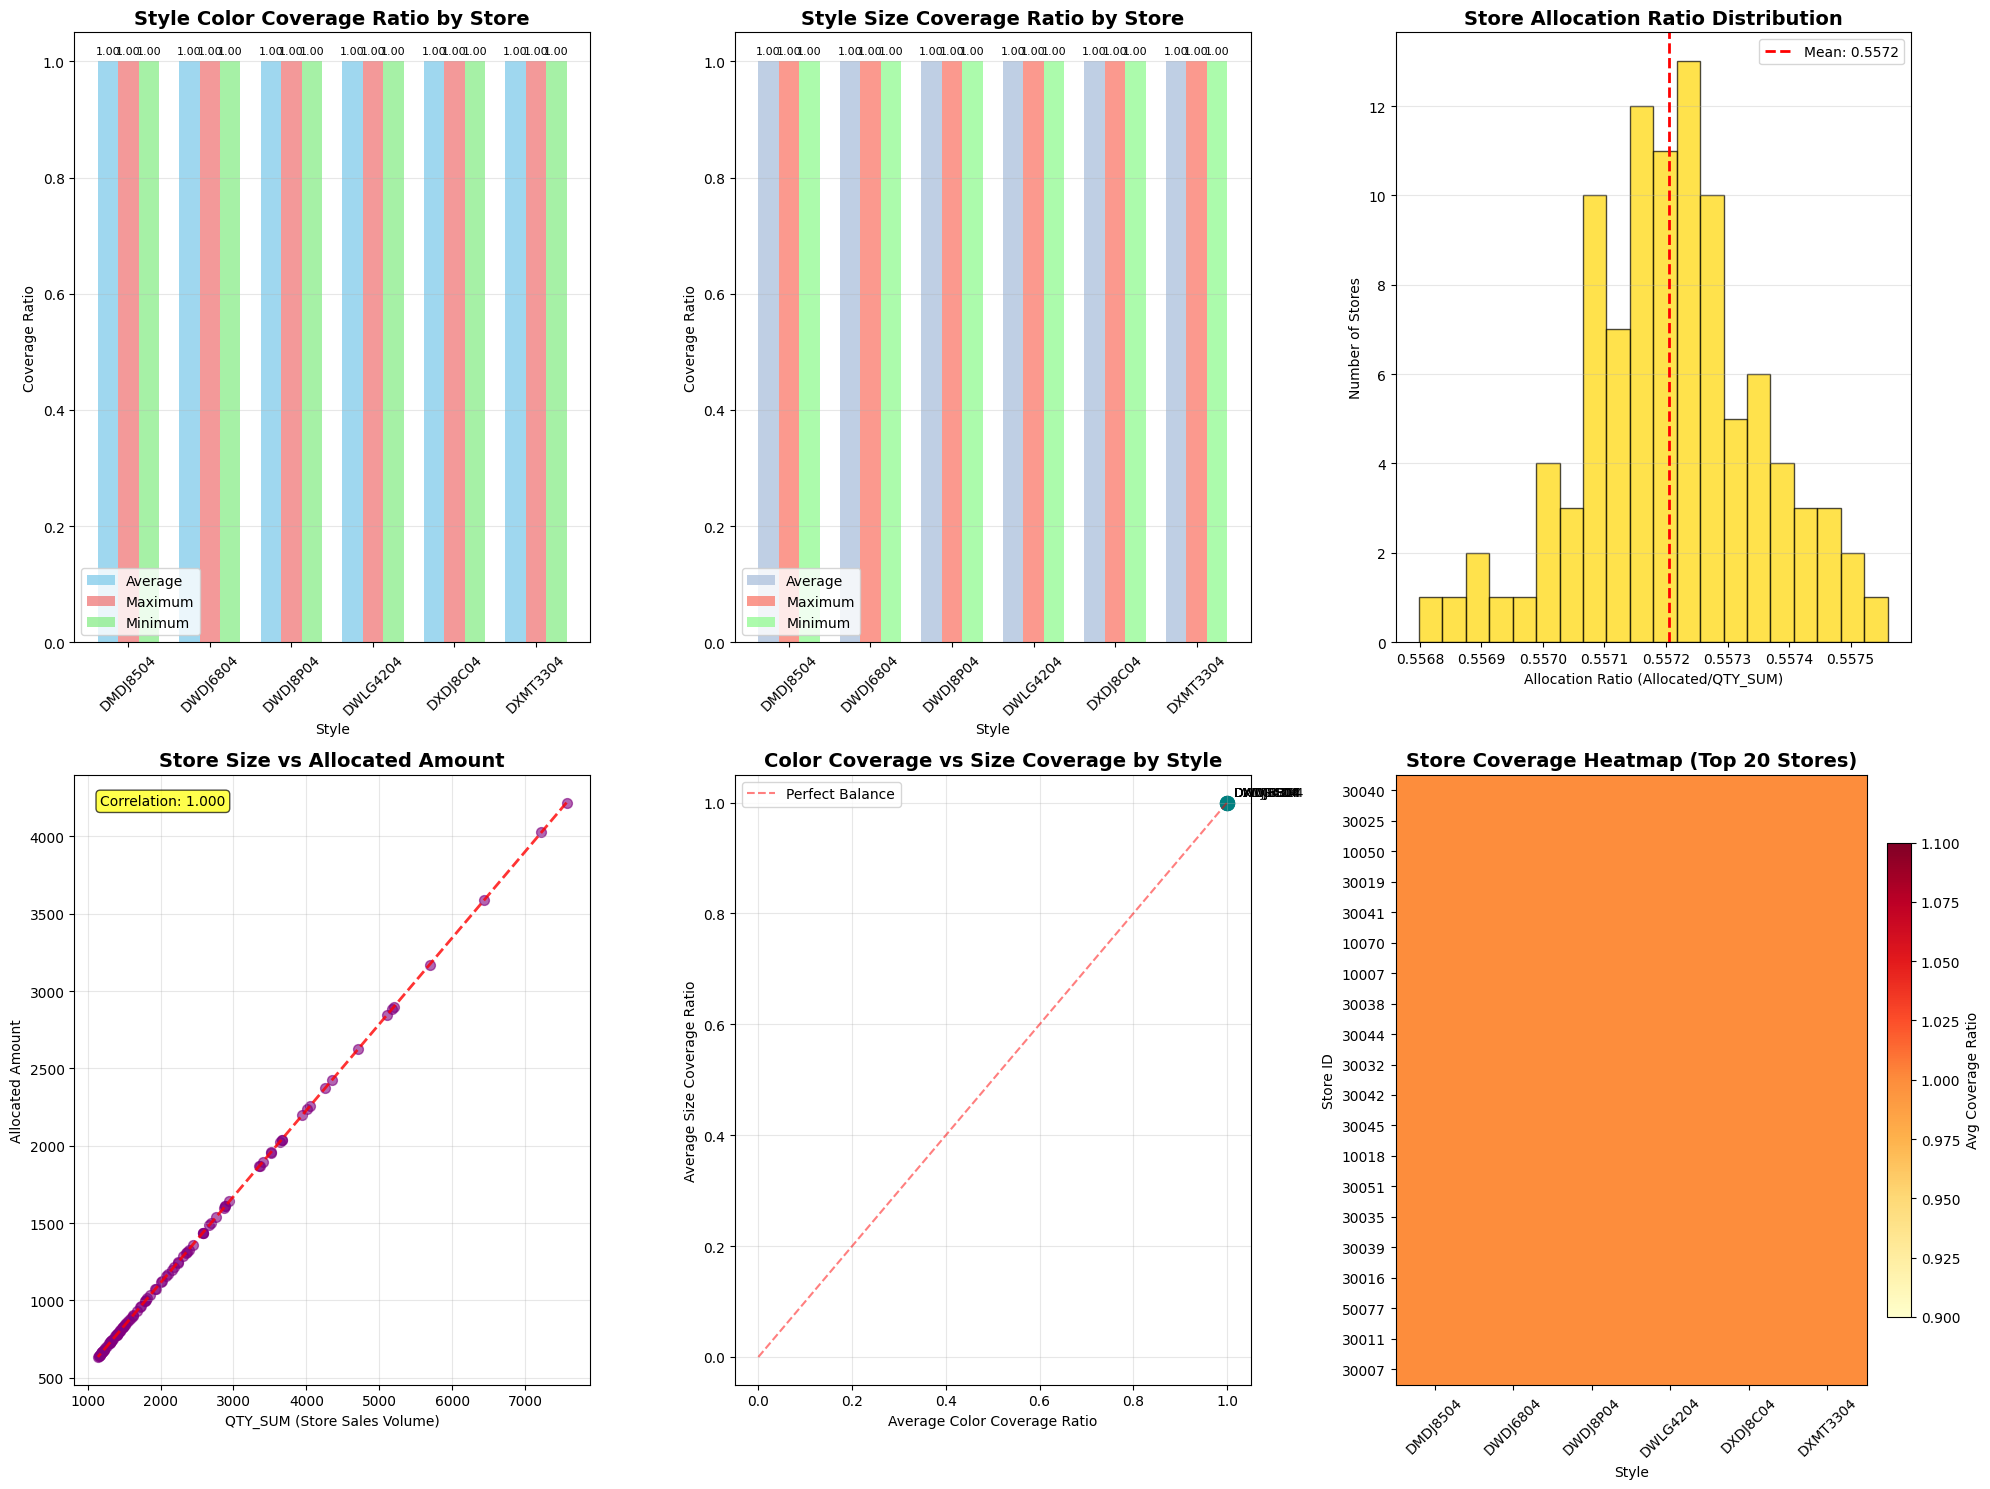

📈 시각화 완료!


In [36]:
# ===== 평가 메트릭 시각화 =====
print("\n🎯 평가 메트릭 시각화 시작...")

# 전체 그래프 설정
fig = plt.figure(figsize=(20, 15))

# ===== 1. 스타일별 컬러 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 1)
style_names = list(style_color_coverage.keys())
color_avg_ratios = [style_color_coverage[s]['avg_ratio'] for s in style_names]
color_max_ratios = [style_color_coverage[s]['max_ratio'] for s in style_names]
color_min_ratios = [style_color_coverage[s]['min_ratio'] for s in style_names]

x_pos = range(len(style_names))
bars1 = plt.bar([x-0.25 for x in x_pos], color_avg_ratios, width=0.25, 
                label='Average', color='skyblue', alpha=0.8)
bars2 = plt.bar(x_pos, color_max_ratios, width=0.25, 
                label='Maximum', color='lightcoral', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], color_min_ratios, width=0.25, 
                label='Minimum', color='lightgreen', alpha=0.8)

plt.title('Style Color Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(color_avg_ratios, color_max_ratios, color_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 2. 스타일별 사이즈 커버리지 비율 막대 그래프 =====
plt.subplot(2, 3, 2)
size_avg_ratios = [style_size_coverage[s]['avg_ratio'] for s in style_names]
size_max_ratios = [style_size_coverage[s]['max_ratio'] for s in style_names]
size_min_ratios = [style_size_coverage[s]['min_ratio'] for s in style_names]

bars1 = plt.bar([x-0.25 for x in x_pos], size_avg_ratios, width=0.25, 
                label='Average', color='lightsteelblue', alpha=0.8)
bars2 = plt.bar(x_pos, size_max_ratios, width=0.25, 
                label='Maximum', color='salmon', alpha=0.8)
bars3 = plt.bar([x+0.25 for x in x_pos], size_min_ratios, width=0.25, 
                label='Minimum', color='palegreen', alpha=0.8)

plt.title('Style Size Coverage Ratio by Store', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Coverage Ratio')
plt.xticks(x_pos, [s[:8] for s in style_names], rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, (avg, max_val, min_val) in enumerate(zip(size_avg_ratios, size_max_ratios, size_min_ratios)):
    plt.text(i-0.25, avg + 0.01, f'{avg:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i, max_val + 0.01, f'{max_val:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(i+0.25, min_val + 0.01, f'{min_val:.2f}', ha='center', va='bottom', fontsize=8)

# ===== 3. 매장별 분배 적정성 비율 히스토그램 =====
plt.subplot(2, 3, 3)
allocation_ratios = [data['ratio'] for data in store_allocation_ratio.values()]

plt.hist(allocation_ratios, bins=20, color='gold', alpha=0.7, edgecolor='black')
plt.title('Store Allocation Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Allocation Ratio (Allocated/QTY_SUM)')
plt.ylabel('Number of Stores')
plt.grid(axis='y', alpha=0.3)

# 통계값 표시
mean_ratio = sum(allocation_ratios) / len(allocation_ratios)
plt.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.4f}')
plt.legend()

# ===== 4. 매장 규모 vs 할당량 산점도 =====
plt.subplot(2, 3, 4)
qty_sums = [store_allocation_ratio[j]['qty_sum'] for j in stores]
allocated_amounts = [store_allocation_ratio[j]['allocated'] for j in stores]

plt.scatter(qty_sums, allocated_amounts, alpha=0.6, s=50, color='purple')
plt.title('Store Size vs Allocated Amount', fontsize=14, fontweight='bold')
plt.xlabel('QTY_SUM (Store Sales Volume)')
plt.ylabel('Allocated Amount')
plt.grid(True, alpha=0.3)

# 추세선 추가
import numpy as np
z = np.polyfit(qty_sums, allocated_amounts, 1)
p = np.poly1d(z)
plt.plot(qty_sums, p(qty_sums), "r--", alpha=0.8, linewidth=2)

# 상관계수 계산
correlation = np.corrcoef(qty_sums, allocated_amounts)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# ===== 5. 스타일별 평균 커버리지 비교 (컬러 vs 사이즈) =====
plt.subplot(2, 3, 5)
plt.scatter(color_avg_ratios, size_avg_ratios, s=100, alpha=0.7, color='teal')

for i, style in enumerate(style_names):
    plt.annotate(style[:8], (color_avg_ratios[i], size_avg_ratios[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Color Coverage vs Size Coverage by Style', fontsize=14, fontweight='bold')
plt.xlabel('Average Color Coverage Ratio')
plt.ylabel('Average Size Coverage Ratio')
plt.grid(True, alpha=0.3)

# 대각선 추가 (이상적인 경우)
max_val = max(max(color_avg_ratios), max(size_avg_ratios))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Balance')
plt.legend()

# ===== 6. 매장별 커버리지 히트맵 (샘플) =====
plt.subplot(2, 3, 6)

# 상위 20개 매장의 스타일별 평균 커버리지 계산
top_stores = sorted(stores, key=lambda j: sum(int(x[i][j].value()) if x[i][j].value() else 0 for i in SKUs), reverse=True)[:20]

heatmap_data = []
for j in top_stores:
    row = []
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        avg_coverage = (color_ratio + size_ratio) / 2
        row.append(avg_coverage)
    heatmap_data.append(row)

im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.title('Store Coverage Heatmap (Top 20 Stores)', fontsize=14, fontweight='bold')
plt.xlabel('Style')
plt.ylabel('Store ID')
plt.xticks(range(len(styles)), [s[:8] for s in styles], rotation=45)
plt.yticks(range(len(top_stores)), [str(j) for j in top_stores])

# 컬러바 추가
plt.colorbar(im, fraction=0.046, pad=0.04, label='Avg Coverage Ratio')

plt.tight_layout()
plt.show()

print("📈 시각화 완료!")


In [37]:
# ===== 상세 분석 테이블 생성 =====
print("\n📋 상세 분석 테이블 생성 중...")

# ===== 1. 스타일별 종합 분석 테이블 =====
style_analysis = []
for s in styles:
    style_data = {
        'Style': s,
        'Total_Colors': len(K_s[s]),
        'Total_Sizes': len(L_s[s]),
        'Avg_Color_Coverage': style_color_coverage[s]['avg_ratio'],
        'Max_Color_Coverage': style_color_coverage[s]['max_ratio'],
        'Min_Color_Coverage': style_color_coverage[s]['min_ratio'],
        'Avg_Size_Coverage': style_size_coverage[s]['avg_ratio'],
        'Max_Size_Coverage': style_size_coverage[s]['max_ratio'],
        'Min_Size_Coverage': style_size_coverage[s]['min_ratio'],
        'Total_SKUs': len(I_s[s]),
        'Scarce_SKUs': len([i for i in I_s[s] if i in scarce]),
        'Abundant_SKUs': len([i for i in I_s[s] if i in abundant])
    }
    style_analysis.append(style_data)

df_style_analysis = pd.DataFrame(style_analysis)
print("\n🎨 스타일별 종합 분석:")
print(df_style_analysis.round(3))

# ===== 2. 매장 성과 분석 (상위/하위 10개 매장) =====
# 종합 성과 점수 계산 (커버리지 + 적정성)
store_performance = {}
for j in stores:
    # 전체 스타일에 대한 평균 커버리지 계산
    total_color_coverage = 0
    total_size_coverage = 0
    for s in styles:
        color_ratio = len(store_coverage[j][s]['colors']) / len(K_s[s]) if len(K_s[s]) > 0 else 0
        size_ratio = len(store_coverage[j][s]['sizes']) / len(L_s[s]) if len(L_s[s]) > 0 else 0
        total_color_coverage += color_ratio
        total_size_coverage += size_ratio
    
    avg_color_coverage = total_color_coverage / len(styles)
    avg_size_coverage = total_size_coverage / len(styles)
    allocation_ratio = store_allocation_ratio[j]['ratio']
    
    # 종합 점수 (커버리지 70% + 적정성 30%)
    performance_score = (avg_color_coverage + avg_size_coverage) * 0.35 + min(allocation_ratio, 1.0) * 0.3
    
    store_performance[j] = {
        'Store_ID': j,
        'Avg_Color_Coverage': avg_color_coverage,
        'Avg_Size_Coverage': avg_size_coverage,
        'Allocation_Ratio': allocation_ratio,
        'Performance_Score': performance_score,
        'Total_Allocated': store_allocation_ratio[j]['allocated'],
        'QTY_SUM': store_allocation_ratio[j]['qty_sum']
    }

# 상위 10개 매장
top_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'], reverse=True)[:10]
df_top_performers = pd.DataFrame(top_performers)
print("\n🏆 상위 성과 매장 Top 10:")
print(df_top_performers.round(4))

# 하위 10개 매장
bottom_performers = sorted(store_performance.values(), key=lambda x: x['Performance_Score'])[:10]
df_bottom_performers = pd.DataFrame(bottom_performers)
print("\n⚠️  하위 성과 매장 Bottom 10:")
print(df_bottom_performers.round(4))

# ===== 3. 희소 SKU 배분 효과성 분석 =====
print("\n🔍 희소 SKU 배분 효과성 분석:")
scarce_effectiveness = {}

for i in scarce:
    # 해당 SKU의 스타일, 색상, 사이즈 추출
    sku_style = df_sku.loc[df_sku['SKU']==i, 'PART_CD'].iloc[0]
    sku_color = df_sku.loc[df_sku['SKU']==i, 'COLOR_CD'].iloc[0]
    sku_size = df_sku.loc[df_sku['SKU']==i, 'SIZE_CD'].iloc[0]
    
    # 할당된 매장 수
    allocated_stores = sum(1 for j in stores if b_hat.get((i,j), 0) == 1)
    
    # 해당 색상/사이즈를 커버하게 된 매장 수 계산
    color_coverage_contribution = 0
    size_coverage_contribution = 0
    
    for j in stores:
        if b_hat.get((i,j), 0) == 1:
            # 이 SKU로 인해 색상 커버리지가 생겼는지 확인
            other_same_color_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                   if sku != i and df_sku.loc[df_sku['SKU']==sku, 'COLOR_CD'].iloc[0] == sku_color]
            if not other_same_color_skus:
                color_coverage_contribution += 1
            
            # 이 SKU로 인해 사이즈 커버리지가 생겼는지 확인  
            other_same_size_skus = [sku for sku in store_coverage[j][sku_style]['allocated_skus'] 
                                  if sku != i and df_sku.loc[df_sku['SKU']==sku, 'SIZE_CD'].iloc[0] == sku_size]
            if not other_same_size_skus:
                size_coverage_contribution += 1
    
    scarce_effectiveness[i] = {
        'SKU': i,
        'Style': sku_style,
        'Color': sku_color,
        'Size': sku_size,
        'Supply_Qty': A[i],
        'Allocated_Stores': allocated_stores,
        'Coverage_Utilization': allocated_stores / A[i] if A[i] > 0 else 0,
        'Color_Coverage_Contribution': color_coverage_contribution,
        'Size_Coverage_Contribution': size_coverage_contribution,
        'Total_Coverage_Impact': color_coverage_contribution + size_coverage_contribution
    }

df_scarce_effectiveness = pd.DataFrame(list(scarce_effectiveness.values()))
print(df_scarce_effectiveness.round(3))

# ===== 4. 최종 종합 평가 =====
print("\n" + "="*60)
print("                  🎯 최종 종합 평가")
print("="*60)

# 전체 성과 메트릭 계산
overall_color_coverage = sum(style_color_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_size_coverage = sum(style_size_coverage[s]['avg_ratio'] for s in styles) / len(styles)
overall_allocation_efficiency = sum(allocation_ratios) / len(allocation_ratios)
allocation_balance = 1 - (max(allocation_ratios) - min(allocation_ratios)) / max(allocation_ratios)  # 균형성

print(f"\n📊 전체 성과 요약:")
print(f"  🎨 평균 색상 커버리지: {overall_color_coverage:.3f} ({overall_color_coverage*100:.1f}%)")
print(f"  📏 평균 사이즈 커버리지: {overall_size_coverage:.3f} ({overall_size_coverage*100:.1f}%)")
print(f"  ⚖️  평균 분배 효율성: {overall_allocation_efficiency:.4f}")
print(f"  🎯 분배 균형성: {allocation_balance:.3f} ({allocation_balance*100:.1f}%)")

# 개선 권장사항
print(f"\n💡 개선 권장사항:")

# 낮은 커버리지 스타일 식별
low_coverage_styles = [(s, style_color_coverage[s]['avg_ratio'], style_size_coverage[s]['avg_ratio']) 
                       for s in styles 
                       if style_color_coverage[s]['avg_ratio'] < 0.5 or style_size_coverage[s]['avg_ratio'] < 0.5]

if low_coverage_styles:
    print("  📉 커버리지 개선 필요 스타일:")
    for style, color_cov, size_cov in low_coverage_styles:
        print(f"    - {style}: 색상 {color_cov:.2f}, 사이즈 {size_cov:.2f}")

# 분배 불균형 매장 식별
high_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] > overall_allocation_efficiency * 2]
low_ratio_stores = [j for j in stores if store_allocation_ratio[j]['ratio'] < overall_allocation_efficiency * 0.5]

if high_ratio_stores:
    print(f"  📈 과도 분배 매장 ({len(high_ratio_stores)}개): {high_ratio_stores[:5]}{'...' if len(high_ratio_stores) > 5 else ''}")
if low_ratio_stores:
    print(f"  📉 과소 분배 매장 ({len(low_ratio_stores)}개): {low_ratio_stores[:5]}{'...' if len(low_ratio_stores) > 5 else ''}")

# 종합 등급 산정
total_score = (overall_color_coverage + overall_size_coverage + min(overall_allocation_efficiency, 1.0) + allocation_balance) / 4

if total_score >= 0.8:
    grade = "A (우수)"
elif total_score >= 0.7:
    grade = "B (양호)"
elif total_score >= 0.6:
    grade = "C (보통)"
elif total_score >= 0.5:
    grade = "D (개선필요)"
else:
    grade = "F (재검토필요)"

print(f"\n🏅 종합 평가 등급: {grade} (점수: {total_score:.3f})")

print("\n✅ 배분 결과 평가 완료!")

# 결과를 CSV로 저장
df_style_analysis.to_csv('../output/style_analysis.csv', index=False, encoding='utf-8-sig')
df_top_performers.to_csv('../output/top_performers.csv', index=False, encoding='utf-8-sig')
df_scarce_effectiveness.to_csv('../output/scarce_effectiveness.csv', index=False, encoding='utf-8-sig')

print(f"\n💾 분석 결과가 CSV 파일로 저장되었습니다:")
print(f"  - 스타일 분석: ../output/style_analysis.csv")
print(f"  - 상위 성과 매장: ../output/top_performers.csv") 
print(f"  - 희소 SKU 효과성: ../output/scarce_effectiveness.csv")



📋 상세 분석 테이블 생성 중...

🎨 스타일별 종합 분석:
       Style  Total_Colors  Total_Sizes  Avg_Color_Coverage  \
0  DMDJ85046             3            4                 1.0   
1  DWDJ68046             5            5                 1.0   
2  DWDJ8P046             5            4                 1.0   
3  DWLG42044             2            4                 1.0   
4  DXDJ8C046             9            6                 1.0   
5  DXMT33044             7            6                 1.0   

   Max_Color_Coverage  Min_Color_Coverage  Avg_Size_Coverage  \
0                 1.0                 1.0                1.0   
1                 1.0                 1.0                1.0   
2                 1.0                 1.0                1.0   
3                 1.0                 1.0                1.0   
4                 1.0                 1.0                1.0   
5                 1.0                 1.0                1.0   

   Max_Size_Coverage  Min_Size_Coverage  Total_SKUs  Scarce_SKUs  \
0    